<a href="https://colab.research.google.com/github/JayNguyen-123/Transfer_Learning_Computer_Vision/blob/main/Ants_and_Bees_Images_Classify_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Transfer Learning for Computer Vision


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import numpy as np
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode


In [4]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Data


In [31]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


### Visualize Images


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


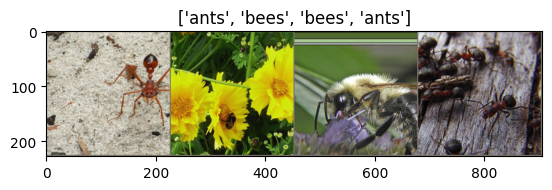

In [8]:
def imshow(inp, title=None):
  # Display iamge for Tensor
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)

  if title is not None:
    plt.title(title)
  plt.pause(0.001)     # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(data_loader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


### Training the Model


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in data_loader[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model





### Visualize the model predictions


In [15]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loader['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f"predicted: {class_names[preds[j]]}")
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)


# Finetuning the ConvNet

In [16]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


### Train and Evaluate


In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.6336 Acc: 0.6516
val Loss: 0.2131 Acc: 0.9276

Epoch 1/24
----------
train Loss: 0.4525 Acc: 0.8156
val Loss: 0.1718 Acc: 0.9145

Epoch 2/24
----------
train Loss: 0.3873 Acc: 0.8607
val Loss: 0.2100 Acc: 0.8947

Epoch 3/24
----------
train Loss: 0.8893 Acc: 0.7377
val Loss: 0.4669 Acc: 0.8224

Epoch 4/24
----------
train Loss: 0.3813 Acc: 0.8443
val Loss: 0.2436 Acc: 0.9145

Epoch 5/24
----------
train Loss: 0.4591 Acc: 0.8197
val Loss: 0.2835 Acc: 0.9079

Epoch 6/24
----------
train Loss: 0.5699 Acc: 0.7828
val Loss: 0.2574 Acc: 0.9013

Epoch 7/24
----------
train Loss: 0.3455 Acc: 0.8648
val Loss: 0.2105 Acc: 0.9211

Epoch 8/24
----------
train Loss: 0.3481 Acc: 0.8402
val Loss: 0.1793 Acc: 0.9408

Epoch 9/24
----------
train Loss: 0.2995 Acc: 0.8648
val Loss: 0.1862 Acc: 0.9474

Epoch 10/24
----------
train Loss: 0.4219 Acc: 0.8320
val Loss: 0.1804 Acc: 0.9408

Epoch 11/24
----------
train Loss: 0.3481 Acc: 0.8484
val Loss: 0.1971 Acc: 0.9211

Epoch 12/24
----------
t

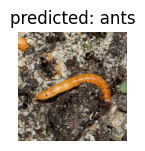

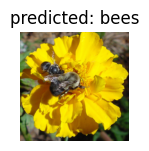

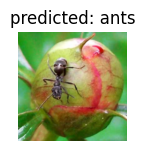

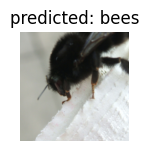

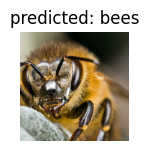

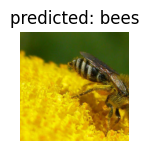

In [19]:
visualize_model(model_ft)


### ConNet as fixed feature axtractor
- we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

In [18]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


### Train and Evaluate


In [20]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6268 Acc: 0.6721
val Loss: 0.3205 Acc: 0.8618

Epoch 1/24
----------
train Loss: 0.4260 Acc: 0.7992
val Loss: 0.3035 Acc: 0.8750

Epoch 2/24
----------
train Loss: 0.3694 Acc: 0.8320
val Loss: 0.3363 Acc: 0.8618

Epoch 3/24
----------
train Loss: 0.6861 Acc: 0.7541
val Loss: 0.2503 Acc: 0.9079

Epoch 4/24
----------
train Loss: 0.6428 Acc: 0.7582
val Loss: 0.2434 Acc: 0.9211

Epoch 5/24
----------
train Loss: 0.4235 Acc: 0.8279
val Loss: 0.3424 Acc: 0.8684

Epoch 6/24
----------
train Loss: 0.5061 Acc: 0.7787
val Loss: 0.1816 Acc: 0.9408

Epoch 7/24
----------
train Loss: 0.4057 Acc: 0.8033
val Loss: 0.2000 Acc: 0.9342

Epoch 8/24
----------
train Loss: 0.3575 Acc: 0.8115
val Loss: 0.2010 Acc: 0.9408

Epoch 9/24
----------
train Loss: 0.3562 Acc: 0.8525
val Loss: 0.1973 Acc: 0.9408

Epoch 10/24
----------
train Loss: 0.3081 Acc: 0.8484
val Loss: 0.2100 Acc: 0.9408

Epoch 11/24
----------
train Loss: 0.3746 Acc: 0.8279
val Loss: 0.1921 Acc: 0.9408

Ep

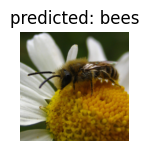

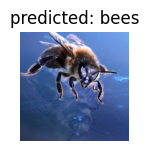

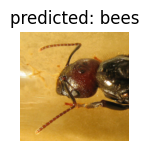

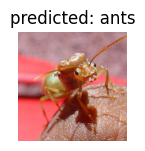

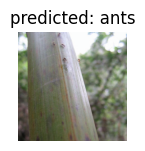

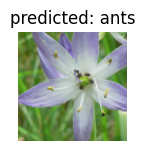

In [23]:
visualize_model(model_conv)

plt.ioff()
plt.show()


### Inference on custom images
- Use the trained model to make predictions on custom images and visualize the predicted class labels along with the images.


In [32]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)


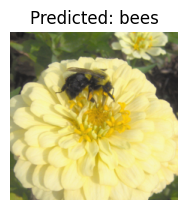

In [33]:
visualize_model_predictions(
    model_conv,
    img_path='/content/44105569_16720a960c.jpg'
)

plt.ioff()
plt.show()
